<a href="https://colab.research.google.com/github/sapperka/AZSII/blob/main/%D0%90%D0%97%D0%A1%D0%98%D0%98_%D0%91%D0%91%D0%9C%D0%9E_02_23_%D0%A0%D1%8B%D0%B1%D0%B0%D0%BA%D0%BE%D0%B2_%D0%9F%D0%A03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# АЗСИИ

# Практика 3: Атака Carlini-Wagner (CW) на модели ИИ

Группа: ББМО-02-23

Студент: Рыбаков Владислав Андреевич

## Цель задания:
Изучить одну из наиболее мощных атак на модели ИИ — атаку Carlini-Wagner (CW).  
Задача — научиться использовать CW для создания противоречивых примеров и исследовать влияние этой атаки на обученные модели.

## Задачи:
1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки Carlini-Wagner.
3. Реализовать атаку CW с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.

## Шаги выполнения:

### Шаг 1: Загрузка обученной модели и данных MNIST

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9740 - loss: 0.0876
Test accuracy on clean images: 0.9768999814987183


### Шаг 2: Теория Carlini-Wagner Attack

Атака Carlini-Wagner (CW) — это одна из наиболее эффективных атак, созданных для введения
моделей в заблуждение. В отличие от FGSM, CW использует оптимизационный подход для создания
минимальных изменений в изображении, которые приводят к ошибке в классификации модели.

Цель атаки — найти минимальные изменения в изображении, которые переводят его в другую
категорию, оставаясь при этом визуально неотличимыми от оригинала.

Атака CW может быть настроена по нескольким параметрам, например, для минимизации L2, L0 или
L∞ норм, что определяет, как именно модифицируется изображение.

### Шаг 3: Установка Foolbox и запуск CW-атаки



Для реализации атаки Carlini-Wagner будем использовать фреймворк Foolbox, который
предоставляет удобные методы для выполнения различных атак на модели ИИ.

In [3]:
!pip install foolbox

Реализация атаки Carlini-Wagner:

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


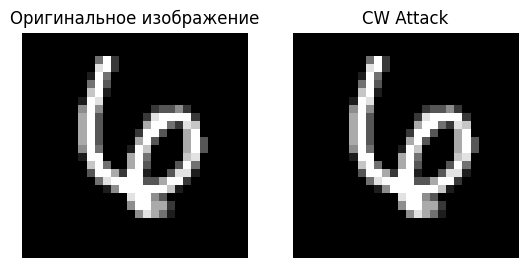

In [4]:
import foolbox as fb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[22], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Создание атаки Carlini-Wagner
attack = fb.attacks.L2CarliniWagnerAttack(steps=5)

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("CW Attack")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

### Шаг 4: Оценка модели на противоречивых примерах
После того, как мы сгенерировали противоречивые примеры, мы можем оценить, насколько атака
Carlini-Wagner влияет на производительность модели.

In [5]:
# Создание набора противоречивых примеров для всего тестового набора

adversarial_images = []
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0887 - loss: 2.4739
Accuracy on adversarial examples (CW attack): 0.0869000032544136


### Вывод:
Резкое снижение точности модели на атакованных примерах до 8,7% по сравнению с оригинальными данными указывает на её уязвимость к небольшим, но целенаправленным искажениям. Это подчеркивает необходимость разработки более устойчивых моделей и внедрения защитных методов для повышения их надежности в реальных условиях.